In [38]:
!pip install pandas
!pip install --upgrade pandas
!pip install --upgrade pip


In [1]:
import pandas as pd
from utils import NOMINAL_COLS, CONTINUOUS_COLS
data_withid = pd.read_csv('data/raw_data/healthcare-dataset-stroke-data.csv')
data_noid = pd.read_csv('data/raw_data/full_data.csv')

# dropping the id column, because I want to concat the dataframes
data_withid.drop(['id'], axis=1, inplace=True)

# append the two dataframes to enlarge tha dataframe
df = pd.concat([data_noid, data_withid], ignore_index=True)
df.to_csv('data/complete_data.csv', index=False)

In [40]:
! pip install sweetviz

In [41]:
# Data understanding, EDA report
import sweetviz as sv
report = sv.analyze(df)
report.show_html('EDA_report/report.html') # Generates a HTML report

                                             |          | [  0%]   00:00 -> (? left)

Report EDA_report/report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [42]:
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn

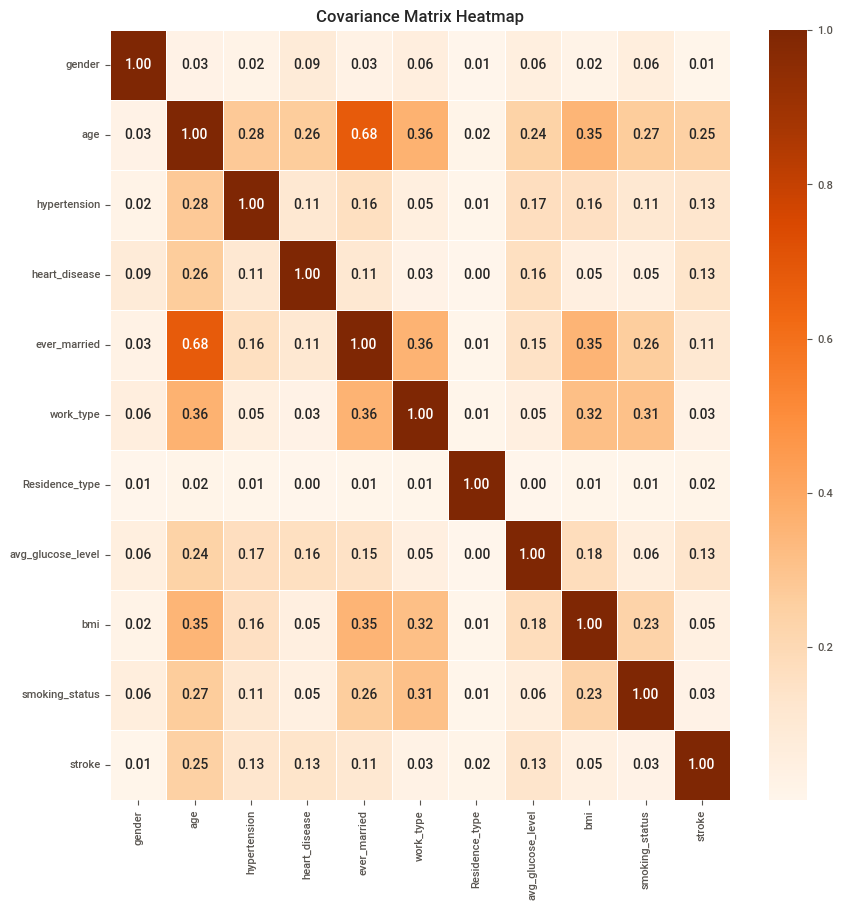

In [43]:
# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler


label_encoder = LabelEncoder()
scaler= StandardScaler()
df_transformed = df.apply(lambda x: label_encoder.fit_transform(x) if x.dtype == 'O' else x)
df_scaled = pd.DataFrame(scaler.fit_transform(df_transformed), columns=df_transformed.columns)
cov_matrix = abs(df_scaled.cov())
plt.figure(figsize=(10, 10))
sns.heatmap(cov_matrix, annot=True, cmap='Oranges', fmt='.2f', linewidths=.5)
plt.title('Covariance Matrix Heatmap')
plt.show()




In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10091 entries, 0 to 10090
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             10091 non-null  object 
 1   age                10091 non-null  float64
 2   hypertension       10091 non-null  int64  
 3   heart_disease      10091 non-null  int64  
 4   ever_married       10091 non-null  object 
 5   work_type          10091 non-null  object 
 6   Residence_type     10091 non-null  object 
 7   avg_glucose_level  10091 non-null  float64
 8   bmi                9890 non-null   float64
 9   smoking_status     10091 non-null  object 
 10  stroke             10091 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 867.3+ KB


In [4]:
# finding null values and filling them
# bmi has 201 null values that is 2% of the data

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean")
df['bmi'] = imputer.fit_transform(df[['bmi']])
df.isnull().any()
# todo First I will fill up missing values with the mean if time allows it I will change it to a regression imputation


gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                  False
smoking_status       False
stroke               False
dtype: bool

In [46]:
# Feature engineering
# Adding two extra columns (diabetic, weight_status)
# diabetic_status: normal, prediabetic, diabetic
# weight_status: normal, underweight, overweight, obese
# these are assumptions

In [47]:
from utils import create_new_features
df = create_new_features(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10091 entries, 0 to 10090
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             10091 non-null  object 
 1   age                10091 non-null  float64
 2   hypertension       10091 non-null  int64  
 3   heart_disease      10091 non-null  int64  
 4   ever_married       10091 non-null  object 
 5   work_type          10091 non-null  object 
 6   Residence_type     10091 non-null  object 
 7   avg_glucose_level  10091 non-null  float64
 8   bmi                10091 non-null  float64
 9   smoking_status     10091 non-null  object 
 10  stroke             10091 non-null  int64  
 11  weight_status      10091 non-null  object 
 12  diabetic_status    10091 non-null  object 
dtypes: float64(3), int64(3), object(7)
memory usage: 1.0+ MB


In [48]:
from sklearn.preprocessing import OneHotEncoder
# Encoding
new_cols = []
encoders = {}
for col in NOMINAL_COLS:
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    new_data = encoder.fit_transform(df[col].to_numpy().reshape(-1, 1))
    
    new_cols.extend(encoder.get_feature_names_out([col]))
    new_df = pd.DataFrame(new_data, columns=encoder.get_feature_names_out([col]))
    df = pd.concat([df, new_df], axis=1)
    encoders[col] = encoder

df.drop(columns=NOMINAL_COLS, inplace=True)
# outliers
from  scipy import stats
for col in CONTINUOUS_COLS:
    df[col + '_zscore'] = stats.zscore(df[col])
    outliers_indices = df[abs(df[col + '_zscore']) > 3].index
    mean = df[col].mean()
    df.loc[outliers_indices, col] = mean
    df.drop(columns=[col + '_zscore'], inplace=True)

In [54]:
from sklearn.preprocessing import MinMaxScaler
# # Scaling
scaler_dict ={}
for col in df.columns:
    scaler = MinMaxScaler()
    df[col] = scaler.fit_transform(df[[col]])
    scaler_dict[col] = scaler

df.min().min()

KeyboardInterrupt: 

In [50]:
#Splitting
from sklearn.model_selection import train_test_split
X = df.drop('stroke', axis=1)
y = df['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_validation, y_train, y_validation = train_test_split(X_train,y_train, test_size=0.2, random_state=42)

In [51]:
# save to csv
df.to_csv('data/processed_data/healthcare-dataset-stroke-data.csv', index=False)
X_train.to_csv('data/processed_data/X_train.csv', index=False)
X_test.to_csv('data/processed_data/X_test.csv', index=False)
y_train.to_csv('data/processed_data/y_train.csv', index=False)
y_test.to_csv('data/processed_data/y_test.csv', index=False)
X_validation.to_csv('data/processed_data/X_validation.csv', index=False)
y_validation.to_csv('data/processed_data/y_validation.csv', index=False)


In [52]:
# saving encoders, and scalers
import pickle
import os

if not os.path.exists('artifacts'):
    os.makedirs('artifacts')
    
with open('artifacts/encoders.pkl', 'wb') as f:
    pickle.dump(encoders, f)
with open('artifacts/scalers.pkl', 'wb') as f:
    pickle.dump(scaler_dict, f)
with open ('artifacts/imputer.pkl', 'wb') as f:
    pickle.dump(imputer, f)